The preprocessing for this data set is quite simple, as the dataset already contains tags_tokenized to eliminate unnecesary words from the data set. Additionally, all numerical values are already scaled between 1 and 0

In [ ]:
print("hello world")
!pip install datasets
import datasets
from datasets import load_dataset


dataSet = load_dataset('csv',data_files='songs.csv')
dataSet['train'] = dataSet['train'].shuffle(seed=42)
print(dataSet)



hello world
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 18.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; plat

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'track_id', 'track_name', 'track_artist', 'track_popularity', 'track_album_release_date', 'playlist_genre', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'liveness', 'valence', 'tempo', 'duration_ms', 'track_artist_merged', 'lyrics', 'artist_name', 'tags', 'tags_tokenized', 'doc_vector', 'combined_vector', 'cluster', 'image_url', 'spotify_url'],
        num_rows: 900
    })
})


In [ ]:
def classify_popularity(examples):
    try:
        track_popularity = float(examples['track_popularity'])
    except ValueError:
        track_popularity = float('nan')
    if track_popularity < 0.1:
        return {'label': 0}
    elif 0.1 <= track_popularity < 0.3:
        return {'label': 1}
    elif track_popularity >= 0.3:
        return {'label': 2}
    else:
        return {'label': -1}

In [ ]:
from transformers import AutoTokenizer

def tokenize_data(dataset, modelname):
    tokenizer = AutoTokenizer.from_pretrained(modelname)
    def tokenize_function(examples):
        return tokenizer(examples['text'], padding = 'max_length', truncation= True)
    return dataset.map(tokenize_function, batched = True)

In [ ]:
def concatenate(dataset):
    dataset['text'] = '[CLS]' + dataset['lyrics'] + ' [SEP]'
    return dataset

In [ ]:
dataSet = dataSet.map(classify_popularity, batched=False)
#print(dataSet['train'].column_names)
#print(dataSet['test'].column_names)
# df = dataSet['train'].to_pandas()


#print(df[['track_popularity', 'popularity_class']].head(50))
model_name = 'distilbert-base-multilingual-cased'



dataset_train = dataSet['train'].select(range(720))
dataset_test = dataSet['train'].select(range(720, len(dataSet['train'])))

ds_train = dataset_train.map(concatenate)
ds_test = dataset_test.map(concatenate)

# print(ds_test['text'][100])
# print(ds_test['popularity_class'][100])


Map:   0%|          | 0/900 [00:00<?, ? examples/s]

Map:   0%|          | 0/720 [00:00<?, ? examples/s]

Map:   0%|          | 0/180 [00:00<?, ? examples/s]

In [ ]:
ds_train = tokenize_data(ds_train, model_name)
ds_test = tokenize_data(ds_test, model_name)
dd = datasets.DatasetDict({"train":ds_train, "test":ds_test})
print(ds_train.column_names)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Map:   0%|          | 0/720 [00:00<?, ? examples/s]

Map:   0%|          | 0/180 [00:00<?, ? examples/s]

['Unnamed: 0', 'track_id', 'track_name', 'track_artist', 'track_popularity', 'track_album_release_date', 'playlist_genre', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'liveness', 'valence', 'tempo', 'duration_ms', 'track_artist_merged', 'lyrics', 'artist_name', 'tags', 'tags_tokenized', 'doc_vector', 'combined_vector', 'cluster', 'image_url', 'spotify_url', 'label', 'text', 'input_ids', 'attention_mask']


In [ ]:
import torch
def get_predictions(model, data):
    """ Get predictions on data for a classification model m returning predictions and true labels"""
    model.eval()
    model.to('cpu')
    predictions = model(torch.tensor(data['input_ids']), torch.tensor(data['attention_mask']))
    predictions = torch.argmax(predictions.logits, dim=-1)
    return predictions, torch.tensor(data['label'])

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


0.38
0.3333333333333333
0.12666666666666668


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


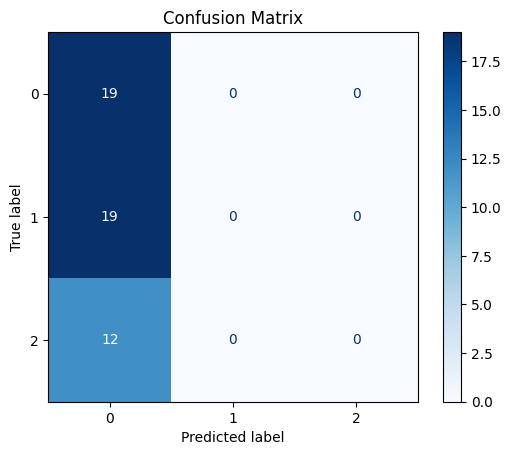

In [ ]:
from transformers import AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score, precision_score, recall_score

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)
y_hat, y = get_predictions(model, dd["test"][:50])

print(accuracy_score(y_hat,y))
print(precision_score(y_hat, y, average='macro'))
print(recall_score(y_hat, y, average='macro'))
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y, y_hat)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

In [ ]:
from transformers import TrainingArguments, Trainer

def train_model(model, train_data, num_epochs):
    """ Train text model for classification """
    training_args = TrainingArguments(output_dir="test_trainer",
                                               num_train_epochs=num_epochs)

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_data['train'],
        eval_dataset=train_data['test']
    )
    trainer.train()

In [ ]:
num_epochs = 5

train_model(model, dd, num_epochs)

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: czeh (czeh-colgate-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss


In [ ]:
num_epochs = 1

train_model(model, dd, num_epochs)

y_hatT, yT = get_predictions(model, dd['train'])
y_hat, y = get_predictions(model, dd['test'])
print(accuracy_score(y_hat, y))
print(precision_score(y_hat, y))
print(recall_score(y_hat, y))
print(accuracy_score(y_hatT, yT))
print(precision_score(y_hatT, yT))
print(recall_score(y_hatT, yT))
cm = confusion_matrix(yT, y_hatT)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix Train")
plt.show()
cm = confusion_matrix(yT, y_hatT)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix Test")
plt.show()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: czeh (czeh-colgate-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss


0.4666666666666667
0.3333333333333333
0.15555555555555556


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


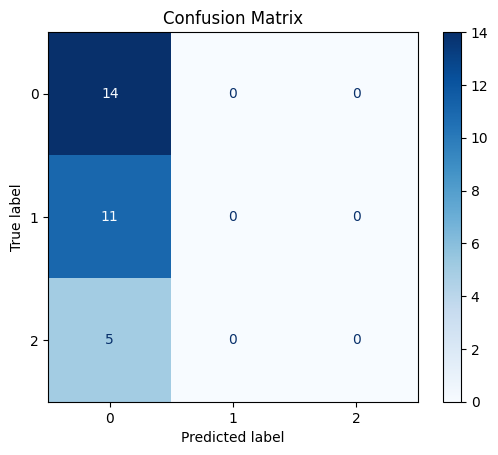

In [ ]:
y_hat, y = get_predictions(model, dd["train"][100:130])

print(accuracy_score(y_hat,y))
print(precision_score(y_hat, y, average='macro'))  # Macro-averaged precision
print(recall_score(y_hat, y, average='macro'))
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y, y_hat)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()